In [153]:
import pandas as pd
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import *
import numpy as np
import math

## Reading the data and cleaning up

In [154]:
dummy=pd.read_fwf('../data/vertebral_column_data/column_2C.dat',names=['vals'])

In [155]:
df = dummy['vals'].str.split(' ', expand=True)

In [156]:
df=df.rename(columns={0:'PI', 1:'PT', 2:'LLA', 3:'SS', 4:'PR', 5:'GOS',6:'class'})
df.head()

,PI,PT,LLA,SS,PR,GOS,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.3,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


In [157]:
df['class'].unique()

array(['AB', 'A', 'NO'], dtype=object)

dropping the row with A in the class column

In [158]:
df[df['class']=='A']

,PI,PT,LLA,SS,PR,GOS,class
197,58.83,37.58,125.74,21.25,135.63,117.31,A


In [159]:
df=df.drop(197)

In [160]:
df['class'].unique()

array(['AB', 'NO'], dtype=object)

In [161]:
df['class']=df['class'].replace({'AB':1,'NO':0})

In [162]:
df['PI']=df['PI'].astype(str).astype(float)
df['PT']=df['PT'].astype(str).astype(float)
df['LLA']=df['LLA'].astype(str).astype(float)
df['SS']=df['SS'].astype(str).astype(float)
df['PR']=df['PR'].astype(str).astype(float)
df['GOS']=df['GOS'].astype(str).astype(float)


In [163]:
#Y=df['class']
#Y.head()

In [164]:
#df.drop('class',axis=1,inplace=True)

In [165]:
df

,PI,PT,LLA,SS,PR,GOS,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,1
1,39.06,10.06,25.02,29.00,114.41,4.56,1
2,68.83,22.22,50.09,46.61,105.99,-3.53,1
3,69.30,24.65,44.31,44.64,101.87,11.21,1
4,49.71,9.65,28.32,40.06,108.17,7.92,1
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,0
306,53.94,20.72,29.22,33.22,114.37,-0.42,0
307,61.45,22.69,46.17,38.75,125.67,-2.71,0
308,45.25,8.69,41.58,36.56,118.55,0.21,0


## (b)(i) Scatterplots on independant variables

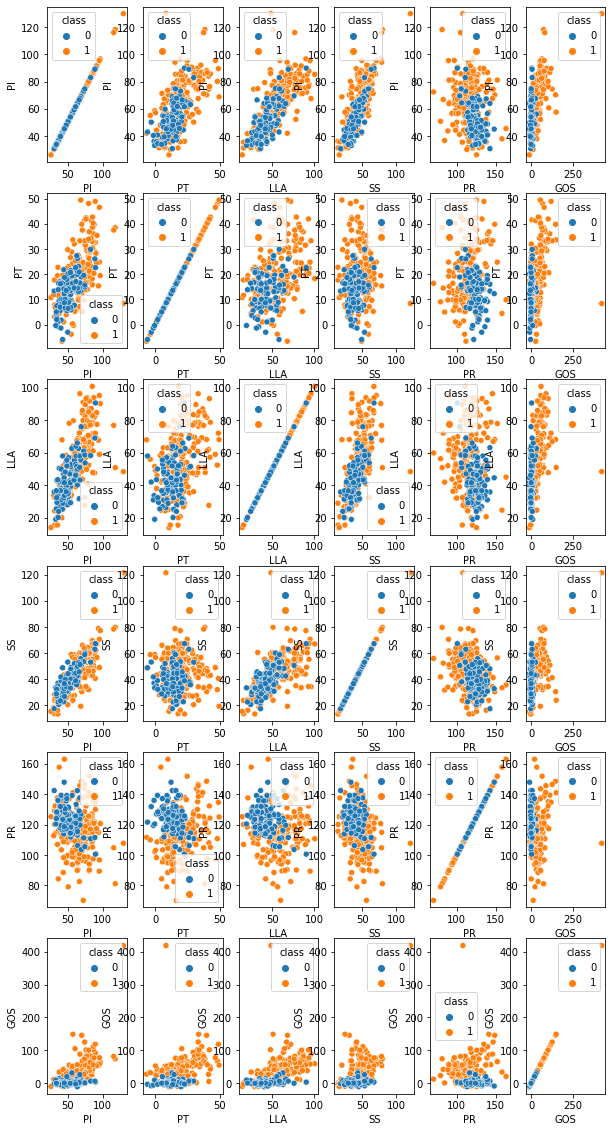

In [166]:
fig, ax = plt.subplots(6,6,figsize=(10,20))
i=0
for y,row in enumerate(df.columns[:-1]):
    for x,col in enumerate(df.columns[:-1]):
        sns.scatterplot(data=df, x=row, y=col, ax=ax[x][y], hue='class')
plt.show()

## (b)(ii) boxplots on independant variables

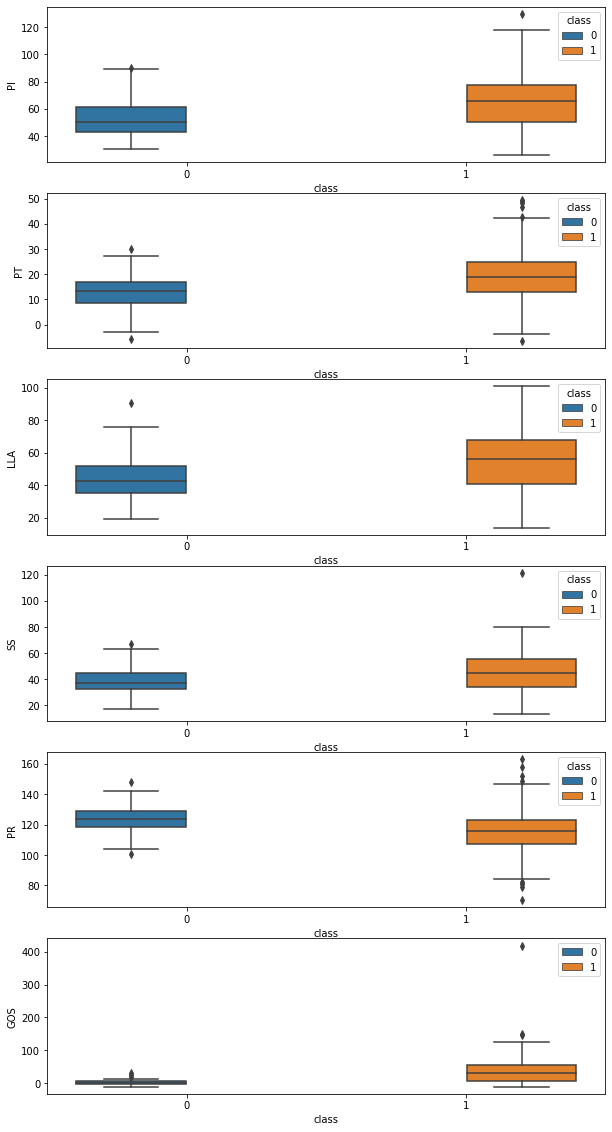

In [167]:
fig, ax = plt.subplots(6,1,figsize=(10,20))
i=0
for col in df.columns[:-1]:
    sns.boxplot(data=df, y=col, x='class', ax=ax[i], hue='class')
    i+=1
plt.legend(loc="upper right")
plt.show()

## (b)(iii) train test data split

In [168]:
train = pd.concat([df[df['class']==0][:70], df[df['class']==1][:140]], ignore_index=True)
train

,PI,PT,LLA,SS,PR,GOS,class
0,38.51,16.96,35.11,21.54,127.63,7.99,0
1,54.92,18.97,51.60,35.95,125.85,2.00,0
2,44.36,8.95,46.90,35.42,129.22,4.99,0
3,48.32,17.45,48.00,30.87,128.98,-0.91,0
4,45.70,10.66,42.58,35.04,130.18,-3.39,0
...,...,...,...,...,...,...,...
205,77.12,30.35,77.48,46.77,110.61,82.09,1
206,88.02,39.84,81.77,48.18,116.60,56.77,1
207,83.40,34.31,78.42,49.09,110.47,49.67,1
208,72.05,24.70,79.87,47.35,107.17,56.43,1


In [169]:
test = pd.concat([df[df['class']==0][70:], df[df['class']==1][140:]], ignore_index=True)
test

,PI,PT,LLA,SS,PR,GOS,class
0,50.09,13.43,34.46,36.66,119.13,3.09,0
1,64.26,14.50,43.90,49.76,115.39,5.95,0
2,53.68,13.45,41.58,40.24,113.91,2.74,0
3,49.00,13.11,51.87,35.88,126.40,0.54,0
4,59.17,14.56,43.20,44.60,121.04,2.83,0
...,...,...,...,...,...,...,...
94,80.11,33.94,85.10,46.17,125.59,100.29,1
95,95.48,46.55,59.00,48.93,96.68,77.28,1
96,74.09,18.82,76.03,55.27,128.41,73.39,1
97,87.68,20.37,93.82,67.31,120.94,76.73,1


## (c)(i) KNN with euclidean metric

In [170]:
def predictions_k_neigh(k, data):
    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    clf.fit(train.iloc[:,:-1], train.iloc[:,-1:].values.ravel())
    return clf.predict(data)

## (c)(ii) Test all the data in the test database with k nearest neighbors

In [171]:
errors = pd.DataFrame({'error':[],'type':[],'k_neigh':[]})
for i in range(208,-1,-3):
    train_error = 1-accuracy_score(train.iloc[:,-1:], predictions_k_neigh(i, train.iloc[:,:-1]))
    test_error = 1-accuracy_score(test.iloc[:,-1:], predictions_k_neigh(i, test.iloc[:,:-1]))
    k_neigh = int(i)
    errors=pd.concat([errors, pd.DataFrame({'error':[train_error],'type':['train'],'k_neigh':[k_neigh]})], ignore_index=True)
    errors=pd.concat([errors, pd.DataFrame({'error':[test_error],'type':['test'],'k_neigh':[k_neigh]})], ignore_index=True)
errors
    

,error,type,k_neigh
0,0.333333,train,208.0
1,0.303030,test,208.0
2,0.333333,train,205.0
3,0.303030,test,205.0
4,0.333333,train,202.0
...,...,...,...
135,0.121212,test,7.0
136,0.142857,train,4.0
137,0.060606,test,4.0
138,0.000000,train,1.0


<AxesSubplot:xlabel='k_neigh', ylabel='error'>

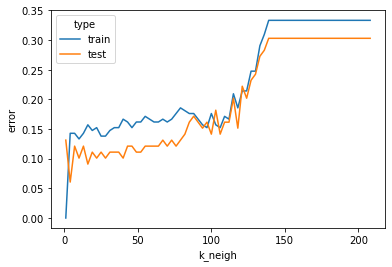

In [172]:
sns.lineplot(data=errors, y='error', x='k_neigh', hue='type')

In [173]:
errors[errors['error']==errors[errors['type']=='test']['error'].min()].min()

error      0.060606
type           test
k_neigh         4.0
dtype: object

k*=4 gives the smallest test error along with a reasonable train error

In [174]:
predictions_4_neigh = predictions_k_neigh(4, test.iloc[:,:-1])
predictions_4_neigh

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [175]:
conf_matrix = confusion_matrix(test.iloc[:,-1:],predictions_4_neigh)
conf_matrix

array([[25,  5],
       [ 1, 68]], dtype=int64)

In [176]:
print(classification_report(test.iloc[:,-1:],predictions_4_neigh))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        30
           1       0.93      0.99      0.96        69

    accuracy                           0.94        99
   macro avg       0.95      0.91      0.93        99
weighted avg       0.94      0.94      0.94        99



PRECISION = 0.93

F1_SCORE = 0.96

TRUE POSITIVE RATE/SENSITIVITY/RECALL = 0.99

TRUE NEGATIVE RATE/SPECIFICITY = 0.83

## (c)(iii) Plot the best test error rate

In [177]:
best_test_error = pd.DataFrame({'test_error':[],'best_k':[],'N':[]})
for N in range(10,220,10):
    min_error = float('inf')
    cur_n = N//3
    cur_best_k = 0
    cur_train = pd.concat([train[train['class']==0][:cur_n], df[df['class']==1][:(N-cur_n)]], ignore_index=True)
    for k in range(1,N,5):
        clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        clf.fit(cur_train.iloc[:,:-1], cur_train.iloc[:,-1:].values.ravel())
        error = 1-accuracy_score(test.iloc[:,-1:], clf.predict(test.iloc[:,:-1]))
        #print(error)
        if min_error>error:
            min_error=error
            cur_best_k = k
    best_test_error=pd.concat([best_test_error, pd.DataFrame({'test_error':[min_error],'best_k':[cur_best_k],'N':[N]})], ignore_index=True)
    
best_test_error


,test_error,best_k,N
0,0.242424,1.0,10.0
1,0.191919,6.0,20.0
2,0.222222,1.0,30.0
3,0.252525,11.0,40.0
4,0.303030,16.0,50.0
5,0.282828,21.0,60.0
6,0.292929,26.0,70.0
7,0.292929,26.0,80.0
8,0.292929,41.0,90.0
9,0.252525,6.0,100.0


<AxesSubplot:xlabel='N', ylabel='test_error'>

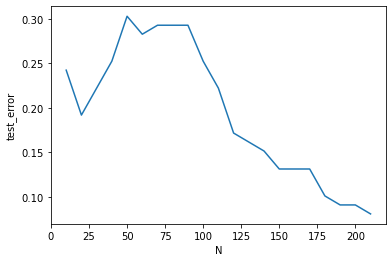

In [178]:
sns.lineplot(data=best_test_error, x='N', y='test_error')

best test error is 0.08 for k=6 and N=210

## (d)(i)(A) manhattan distance p=1

In [179]:
def predictions_k_neigh(k, data, cur_p):
    clf = KNeighborsClassifier(n_neighbors=k, p=cur_p)
    clf.fit(train.iloc[:,:-1], train.iloc[:,-1:].values.ravel())
    return clf.predict(data)

In [180]:
errors = pd.DataFrame({'error':[],'type':[],'k_neigh':[]})
for i in range(196,-4,-5):
    train_error = 1-accuracy_score(train.iloc[:,-1:], predictions_k_neigh(i, train.iloc[:,:-1], 1))
    test_error = 1-accuracy_score(test.iloc[:,-1:], predictions_k_neigh(i, test.iloc[:,:-1], 1))
    k_neigh = int(i)
    errors=pd.concat([errors, pd.DataFrame({'error':[train_error],'type':['train'],'k_neigh':[k_neigh]})], ignore_index=True)
    errors=pd.concat([errors, pd.DataFrame({'error':[test_error],'type':['test'],'k_neigh':[k_neigh]})], ignore_index=True)
errors
    

,error,type,k_neigh
0,0.333333,train,196.0
1,0.303030,test,196.0
2,0.333333,train,191.0
3,0.303030,test,191.0
4,0.333333,train,186.0
...,...,...,...
75,0.111111,test,11.0
76,0.138095,train,6.0
77,0.111111,test,6.0
78,0.000000,train,1.0


In [181]:
errors[errors['error']==errors[errors['type']=='test']['error'].min()].min()

error      0.111111
type           test
k_neigh         6.0
dtype: object

k=6 with test error as 0.11

## (d)(i)(B) with log10(p) in {0.1,0.2...1}

In [182]:
def predictions_k_neigh(k, data, log_p):
    clf = KNeighborsClassifier(n_neighbors=k, p=10**(log_p))
    clf.fit(train.iloc[:,:-1], train.iloc[:,-1:].values.ravel())
    return clf.predict(data)

In [183]:
errors = pd.DataFrame({'error':[],'type':[],'log p':[]})
p=0.1
while p<=1:
    k = 6
    train_error = 1-accuracy_score(train.iloc[:,-1:], predictions_k_neigh(k, train.iloc[:,:-1], p))
    test_error = 1-accuracy_score(test.iloc[:,-1:], predictions_k_neigh(k, test.iloc[:,:-1], p))
    k_neigh = int(i)
    errors=pd.concat([errors, pd.DataFrame({'error':[train_error],'type':['train'],'log p':[p]})], ignore_index=True)
    errors=pd.concat([errors, pd.DataFrame({'error':[test_error],'type':['test'],'log p':[p]})], ignore_index=True)
    p+=0.1
errors  

,error,type,log p
0,0.138095,train,0.1
1,0.090909,test,0.1
2,0.147619,train,0.2
3,0.090909,test,0.2
4,0.152381,train,0.3
5,0.080808,test,0.3
6,0.152381,train,0.4
7,0.080808,test,0.4
8,0.147619,train,0.5
9,0.080808,test,0.5


In [184]:
errors[errors['error']==errors[errors['type']=='test']['error'].min()].min()

error    0.060606
type         test
log p         0.6
dtype: object

test error = 0.06 with logp=0.6

## (d)(i)(C) chebyshev distance p->inf

In [185]:
def predictions_k_neigh(k, data):
    clf = KNeighborsClassifier(n_neighbors=k,metric='chebyshev')
    clf.fit(train.iloc[:,:-1], train.iloc[:,-1:].values.ravel())
    return clf.predict(data)

In [186]:
errors = pd.DataFrame({'error':[],'type':[],'k_neigh':[]})
for i in range(196,-4,-5):
    train_error = 1-accuracy_score(train.iloc[:,-1:], predictions_k_neigh(i, train.iloc[:,:-1]))
    test_error = 1-accuracy_score(test.iloc[:,-1:], predictions_k_neigh(i, test.iloc[:,:-1]))
    k_neigh = int(i)
    errors=pd.concat([errors, pd.DataFrame({'error':[train_error],'type':['train'],'k_neigh':[k_neigh]})], ignore_index=True)
    errors=pd.concat([errors, pd.DataFrame({'error':[test_error],'type':['test'],'k_neigh':[k_neigh]})], ignore_index=True)
errors
    

,error,type,k_neigh
0,0.333333,train,196.0
1,0.303030,test,196.0
2,0.333333,train,191.0
3,0.303030,test,191.0
4,0.333333,train,186.0
...,...,...,...
75,0.121212,test,11.0
76,0.152381,train,6.0
77,0.101010,test,6.0
78,0.000000,train,1.0


In [187]:
errors[errors['error']==errors[errors['type']=='test']['error'].min()].min()

error      0.080808
type           test
k_neigh        16.0
dtype: object

test error = 0.08 for k=16

## (d)(ii) Mahalanobis distance

In [188]:
def predictions_k_neigh(k, data):
    clf = KNeighborsClassifier(n_neighbors=k,metric='mahalanobis', metric_params={'VI': np.linalg.inv(np.cov(train.iloc[:,:-1].T))})
    clf.fit(train.iloc[:,:-1], train.iloc[:,-1:].values.ravel())
    return clf.predict(data)

In [189]:
errors = pd.DataFrame({'error':[],'type':[],'k_neigh':[]})
for i in range(196,-4,-5):
    train_error = 1-accuracy_score(train.iloc[:,-1:], predictions_k_neigh(i, train.iloc[:,:-1]))
    test_error = 1-accuracy_score(test.iloc[:,-1:], predictions_k_neigh(i, test.iloc[:,:-1]))
    k_neigh = int(i)
    errors=pd.concat([errors, pd.DataFrame({'error':[train_error],'type':['train'],'k_neigh':[k_neigh]})], ignore_index=True)
    errors=pd.concat([errors, pd.DataFrame({'error':[test_error],'type':['test'],'k_neigh':[k_neigh]})], ignore_index=True)
errors
    

,error,type,k_neigh
0,0.333333,train,196.0
1,0.303030,test,196.0
2,0.333333,train,191.0
3,0.303030,test,191.0
4,0.333333,train,186.0
...,...,...,...
75,0.202020,test,11.0
76,0.119048,train,6.0
77,0.171717,test,6.0
78,0.000000,train,1.0


In [190]:
errors[errors['error']==errors[errors['type']=='test']['error'].min()]

,error,type,k_neigh
77,0.171717,test,6.0
79,0.171717,test,1.0


both k=6 and k=1 give the least test error as 0.17. Ignoring k=1 as it may cause the data to overfit. 
Hence, the k* for which the training error is the least for this case would be k=6

## (e) weighted voting 

Euclidean

In [191]:
def predictions_k_neigh(k, data):
    clf = KNeighborsClassifier(n_neighbors=k,metric='euclidean', weights='distance')
    clf.fit(train.iloc[:,:-1], train.iloc[:,-1:].values.ravel())
    return clf.predict(data)

In [192]:
errors = pd.DataFrame({'error':[],'type':[],'k_neigh':[]})
for i in range(196,-4,-5):
    #train_error = 1-accuracy_score(train.iloc[:,-1:], predictions_k_neigh(i, train.iloc[:,:-1]))
    test_error = 1-accuracy_score(test.iloc[:,-1:], predictions_k_neigh(i, test.iloc[:,:-1]))
    k_neigh = int(i)
    #errors=pd.concat([errors, pd.DataFrame({'error':[train_error],'type':['train'],'k_neigh':[k_neigh]})], ignore_index=True)
    errors=pd.concat([errors, pd.DataFrame({'error':[test_error],'type':['test'],'k_neigh':[k_neigh]})], ignore_index=True)
errors
    

,error,type,k_neigh
0,0.282828,test,196.0
1,0.282828,test,191.0
2,0.272727,test,186.0
3,0.272727,test,181.0
4,0.272727,test,176.0
5,0.272727,test,171.0
6,0.252525,test,166.0
7,0.232323,test,161.0
8,0.202020,test,156.0
9,0.191919,test,151.0


In [193]:
errors[errors['error']==errors[errors['type']=='test']['error'].min()].min()

error      0.10101
type          test
k_neigh        6.0
dtype: object

test error=0.1 for k=6

Manhattan

In [194]:
def predictions_k_neigh(k, data):
    clf = KNeighborsClassifier(n_neighbors=k,metric='euclidean', weights='distance')
    clf.fit(train.iloc[:,:-1], train.iloc[:,-1:].values.ravel())
    return clf.predict(data)

In [195]:
errors = pd.DataFrame({'error':[],'type':[],'k_neigh':[]})
for i in range(196,-4,-5):
    #train_error = 1-accuracy_score(train.iloc[:,-1:], predictions_k_neigh(i, train.iloc[:,:-1]))
    test_error = 1-accuracy_score(test.iloc[:,-1:], predictions_k_neigh(i, test.iloc[:,:-1]))
    k_neigh = int(i)
    #errors=pd.concat([errors, pd.DataFrame({'error':[train_error],'type':['train'],'k_neigh':[k_neigh]})], ignore_index=True)
    errors=pd.concat([errors, pd.DataFrame({'error':[test_error],'type':['test'],'k_neigh':[k_neigh]})], ignore_index=True)
errors
    

,error,type,k_neigh
0,0.282828,test,196.0
1,0.282828,test,191.0
2,0.272727,test,186.0
3,0.272727,test,181.0
4,0.272727,test,176.0
5,0.272727,test,171.0
6,0.252525,test,166.0
7,0.232323,test,161.0
8,0.202020,test,156.0
9,0.191919,test,151.0


In [196]:
errors[errors['error']==errors[errors['type']=='test']['error'].min()].min()

error      0.10101
type          test
k_neigh        6.0
dtype: object

Chebyshev

In [197]:
def predictions_k_neigh(k, data):
    clf = KNeighborsClassifier(n_neighbors=k, metric='chebyshev', weights='distance')
    clf.fit(train.iloc[:,:-1], train.iloc[:,-1:].values.ravel())
    return clf.predict(data)

In [198]:
errors = pd.DataFrame({'error':[],'type':[],'k_neigh':[]})
for i in range(196,-4,-5):
    #train_error = 1-accuracy_score(train.iloc[:,-1:], predictions_k_neigh(i, train.iloc[:,:-1]))
    test_error = 1-accuracy_score(test.iloc[:,-1:], predictions_k_neigh(i, test.iloc[:,:-1]))
    k_neigh = int(i)
    #errors=pd.concat([errors, pd.DataFrame({'error':[train_error],'type':['train'],'k_neigh':[k_neigh]})], ignore_index=True)
    errors=pd.concat([errors, pd.DataFrame({'error':[test_error],'type':['test'],'k_neigh':[k_neigh]})], ignore_index=True)
errors
    

,error,type,k_neigh
0,0.282828,test,196.0
1,0.272727,test,191.0
2,0.272727,test,186.0
3,0.272727,test,181.0
4,0.262626,test,176.0
5,0.262626,test,171.0
6,0.262626,test,166.0
7,0.232323,test,161.0
8,0.212121,test,156.0
9,0.212121,test,151.0


In [199]:
errors[errors['error']==errors[errors['type']=='test']['error'].min()].min()

error      0.111111
type           test
k_neigh        16.0
dtype: object

test error=0.11 for k=16

## (f) lowest training error

The lowest training error is 0 when k=1 for any distance metric or p 